In [489]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline

# Data preprocessing 
## Data preparation:
* Replace NA values
* Parse date-time into pandas dataframe index
* Specified clear names for each columns

In [490]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

In [491]:
dataset = pd.read_csv('data_hrly.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
print("||"*40)
print("** DATA PROCESSING COMPLETED **")
print(dataset.head(5))
print("||"*40)
dataset.to_csv('pollution.csv')

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA PROCESSING COMPLETED **
                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [492]:
dataset = pd.read_csv('pollution.csv',index_col='date')

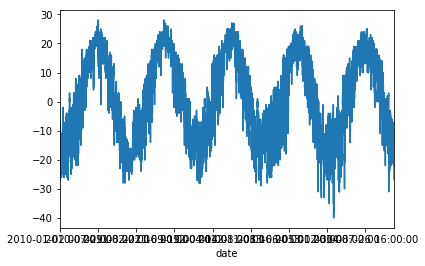

In [493]:
dataset['dew'].plot()

In [494]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
lbe = LabelEncoder()
ohe = OneHotEncoder(categorical_features=[4])
scaler = MinMaxScaler()


In [496]:
dataset = pd.read_csv('pollution.csv',index_col='date')
dataset['wnd_dir'] = lbe.fit_transform(dataset['wnd_dir'])
dataset= ohe.fit_transform(dataset).toarray()
dataset = dataset[:,1:]
dataset = scaler.fit_transform(dataset)
print("Shape: ",dataset.shape)

Shape:  (43800, 10)


In [497]:
training_set = dataset[:40000,:]
test_set = dataset[40000:,:]

In [498]:
test_set.shape

(3800, 10)

# Data format

In [499]:
for x in (dataset[0]):
    print(x)

0.0
1.0
0.0
0.129778672032
0.352941176471
0.245901639344
0.527272727273
0.00229001110826
0.0
0.0


In [500]:
def next_batch(training_data,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # This means you should limit the starting point to len(data)-steps
    
    ts_start = np.random.randint(low = 0, high = len(training_data)-steps)
    # STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps + 1. Then reshape this data to be (1,steps+1)
    y_batch = training_data[ts_start: ts_start + steps + 1]
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # You'll need to reshape these into tensors for the RNN to .reshape(-1,steps,1)
    return y_batch[:-1,:].reshape(-1,steps,10) , y_batch[1:,[3]].reshape(-1,steps,1)
    

In [501]:
x,y = next_batch(training_data=training_set,steps=100)

In [502]:
training_set[31671: 31671 + 100 + 1][:-1,:].shape

(100, 10)

In [503]:
training_set[31671: 31671 + 100 + 1].shape

(101, 10)

In [443]:
x.shape

(1, 100, 10)

In [444]:
y.shape

(1, 100, 1)

In [445]:
y[0][0]

array([ 0.11871227])

In [446]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf

In [509]:
tf.reset_default_graph()

In [510]:
NUMBER_NEU = 128
N_IP = 10
N_OP = 1
STEPS = 10
LR = 0.005
ITER = 10000

In [511]:
#Placeholders
x = tf.placeholder(dtype=tf.float32,shape=(None,STEPS,N_IP))
y = tf.placeholder(dtype=tf.float32,shape=(None,STEPS,N_OP))
hold_proba = tf.placeholder(dtype=tf.float32)

In [512]:
cell_1 = tf.contrib.rnn.DropoutWrapper((tf.contrib.rnn.BasicLSTMCell(num_units=NUMBER_NEU,activation=tf.nn.relu)),input_keep_prob=hold_proba)
cell_2 = tf.contrib.rnn.DropoutWrapper((tf.contrib.rnn.BasicLSTMCell(num_units=NUMBER_NEU,activation=tf.nn.relu)),input_keep_prob=hold_proba)
final_cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.MultiRNNCell([cell_1,cell_2]),output_size=N_OP)

In [513]:
output , states = tf.nn.dynamic_rnn(final_cell,inputs=x, dtype=tf.float32)

In [514]:
loss = tf.reduce_mean(tf.square(output-y))
optim = tf.train.AdamOptimizer(learning_rate=LR)
train = optim.minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [516]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(ITER):
        x_batch,y_batch = next_batch(training_set,steps=STEPS)
        sess.run(train,feed_dict = {x:x_batch, y: y_batch, hold_proba:0.8})
        if i % 100 == 0:
            print("At step",i,"\tMSE :", sess.run(loss,feed_dict = {x:x_batch, y: y_batch,hold_proba:1.0}))
    saver.save(sess, "Temp/model")

At step 0 	MSE : 0.0220306
At step 100 	MSE : 0.000697338
At step 200 	MSE : 0.00140382
At step 300 	MSE : 0.00571872
At step 400 	MSE : 0.000859667
At step 500 	MSE : 0.00155051
At step 600 	MSE : 0.00306969
At step 700 	MSE : 0.000786854
At step 800 	MSE : 0.00389771
At step 900 	MSE : 0.00478927
At step 1000 	MSE : 0.000257432
At step 1100 	MSE : 0.00373574
At step 1200 	MSE : 0.000719199
At step 1300 	MSE : 0.00342112
At step 1400 	MSE : 0.000280246
At step 1500 	MSE : 0.000591191
At step 1600 	MSE : 0.000152969
At step 1700 	MSE : 0.0171448
At step 1800 	MSE : 0.00043112
At step 1900 	MSE : 0.000380652
At step 2000 	MSE : 0.000235864
At step 2100 	MSE : 0.00166626
At step 2200 	MSE : 0.0021619
At step 2300 	MSE : 0.000540035
At step 2400 	MSE : 0.0014566
At step 2500 	MSE : 0.00236403
At step 2600 	MSE : 0.000222253
At step 2700 	MSE : 0.000744648
At step 2800 	MSE : 0.00031323
At step 2900 	MSE : 0.00235275
At step 3000 	MSE : 0.000135577
At step 3100 	MSE : 0.00108429
At step 32

In [407]:
# CODE HERE
pred = []
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "TEMP/model")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
    train_seed = list(training_set[-10:])
    test_ind = 0
    ## Now create a for loop that 
    for iteration in range(12):
        print(train_seed[-1:])
        X_batch = np.array(train_seed[-STEPS:]).reshape(1, STEPS, 10)
        y_pred = sess.run(output, feed_dict={x: X_batch})
        pred.append(y_pred[0, -1, 0])
        train_seed.append(np.array(list(test_set[test_ind]).append(y_pred[0, -1, 0])))
        test_ind+=1
        

INFO:tensorflow:Restoring parameters from TEMP/model
[array([ 0.        ,  1.        ,  0.        ,  0.06740443,  0.83823529,
        0.8852459 ,  0.29090909,  0.01297103,  0.        ,  0.        ])]
[array(None, dtype=object)]


ValueError: cannot reshape array of size 10 into shape (1,10,10)

In [400]:
training_set[-10:]

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.49899396e-01,   8.67647059e-01,   6.72131148e-01,
          3.09090909e-01,   5.33196616e-03,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.42857143e-01,   8.82352941e-01,   7.21311475e-01,
          3.27272727e-01,   7.51943946e-04,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.37826962e-01,   8.82352941e-01,   7.54098361e-01,
          3.27272727e-01,   2.27292147e-03,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.13682093e-01,   8.82352941e-01,   7.86885246e-01,
          3.27272727e-01,   3.79389900e-03,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.19718310e-01,   8.82352941e-01,   8.03278689e-01,
          3.27272727e-01